In [385]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.set_printoptions(threshold=10000,suppress=True) 
filterwarnings('ignore')

CREDIT_SCORE = "../data/credit_scoring.csv"

# I) Apprentissage supervisé : Feature engineering et Classification

## **1) Chargement des données et préparation :**

In [386]:
from sklearn.model_selection import train_test_split


# chargement des données
pd_credit = pd.read_csv(CREDIT_SCORE, sep=";")
np_credit = pd_credit.values

# séparation entre donnée "input": X et les labels: Y
X, Y = np_credit[:, :-1], np_credit[:, -1]

# séparation des données en test et train
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.5, random_state=1)

# exploration des données
txt = f"""Le jeu de donnée présente:
    {X.shape[0]:<6d} enregistrements
    {X.shape[1]:<6d} variables explicatives
    {1:<6d} variable label/classification

Concernant la classification, elle est binaire (0 ou 1) avec:
    {int(Y.sum()):<6d} classe 1 = solvable
    {int(len(Y) - Y.sum()):<6d} classe 0 = non solvable 
"""
print(txt)

display(pd_credit.head())

Le jeu de donnée présente:
    4375   enregistrements
    13     variables explicatives
    1      variable label/classification

Concernant la classification, elle est binaire (0 ou 1) avec:
    3159   classe 1 = solvable
    1216   classe 0 = non solvable 



,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price,Status
0,9.0,1.0,60.0,30.0,0.0,1.0,1.0,73.0,129.0,0.0,0.0,800.0,846.0,1
1,17.0,1.0,60.0,58.0,1.0,1.0,0.0,48.0,131.0,0.0,0.0,1000.0,1658.0,1
2,10.0,0.0,36.0,46.0,0.0,2.0,1.0,90.0,200.0,3000.0,0.0,2000.0,2985.0,0
3,0.0,1.0,60.0,24.0,1.0,1.0,0.0,63.0,182.0,2500.0,0.0,900.0,1325.0,1
4,0.0,1.0,36.0,26.0,1.0,1.0,0.0,46.0,107.0,0.0,0.0,310.0,910.0,1


## **2) Apprentissage et évaluation de modèles :**

In [387]:
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                             recall_score)

COLS_EVAL = ["method", "comment", "precision", "accuracy", "recall", "VP", "VN", "FP", "FN", "args"]

def test_model(X_train, Y_train, X_test, Y_test, sk_fun, comment="", **kwargs):
    
    model = sk_fun(**kwargs)      # call a model
    model.fit(X_train, Y_train)     # training
    Y_pred = model.predict(X_test)    # testing
    
    # metrics
    pr, acc, rec = precision_score(Y_test, Y_pred), accuracy_score(Y_test, Y_pred), recall_score(Y_test, Y_pred)
    Conf = confusion_matrix(Y_test, Y_pred)

    # maj df_eval
    line = [sk_fun.__name__, comment, pr, acc, rec, Conf[1, 1], Conf[0, 0], Conf[0, 1], Conf[1, 0], [str(kwargs)]]
    line_df = pd.DataFrame({k:v for k, v in zip(COLS_EVAL, line)}, columns=COLS_EVAL)

    # display confusion matrix
    print(f"Confusion matrix with {sk_fun.__name__} {comment} {str(kwargs)}")
    display(pd.DataFrame(Conf, index=["is 0", "is 1"], columns=["predicted 0", "predicted 1"]))
    
    return line_df

comparative_df = pd.DataFrame(columns=COLS_EVAL)

In [388]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

datas=(xtrain, ytrain, xtest, ytest)

# CART test
cart_test = test_model(*datas, DecisionTreeClassifier, random_state=1)

# KNN test
knn_test = test_model(*datas, KNeighborsClassifier, n_neighbors=5)

# MLP test
mlp_test = test_model(*datas, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1)

comparative_df = pd.concat([comparative_df, cart_test, knn_test, mlp_test], ignore_index=True)
#drop duplicate line (if multiple evaluations this cells)
comparative_df = comparative_df.drop_duplicates()

Confusion matrix with DecisionTreeClassifier  {'random_state': 1}


,predicted 0,predicted 1
is 0,325,279
is 1,318,1266


Confusion matrix with KNeighborsClassifier  {'n_neighbors': 5}


,predicted 0,predicted 1
is 0,189,415
is 1,187,1397


Confusion matrix with MLPClassifier  {'hidden_layer_sizes': (40, 20), 'random_state': 1}


,predicted 0,predicted 1
is 0,118,486
is 1,180,1404


In [ ]:
display(comparative_df.sort_values("precision", ascending=False))

,method,comment,precision,accuracy,recall,VP,VN,FP,FN,args
0,DecisionTreeClassifier,,0.819417,0.727148,0.799242,1266,325,279,318,{'random_state': 1}
2,MLPClassifier,,0.819331,0.668647,0.695707,1102,361,243,482,"{'hidden_layer_sizes': (40, 20), 'random_state..."
1,KNeighborsClassifier,,0.770971,0.724863,0.881944,1397,189,415,187,{'n_neighbors': 5}


On définit la **precision** (ou **positive predictive value**): $\frac{VP}{VP+FP}$ "Parmis les prédictions positives, lesquelles sont justes".

On définit l'**accuracy** : $\frac{VP+FN}{VP+FP+VN+FN}$ "Parmis l'ensemble des prédictions, lesquelles sont justes".

On définit le **recall** (ou **sensibilité** ou **true positive rate**): $\frac{VP}{VP+FN}$ "Parmis les cas postifs, lesquelles sont correctements détectés"

Dans notre situation, nous représentons l'assureur, nous voulons éviter les impayés ! il faut alors minimiser au possible les **faux positifs** (c'est à dire ne pas attribuer un prêt alors qu'un agent ne l'aurait pas fait). 
Ainsi le critère de **précision** est plus important que le recall puisque son calcul prend en compte les faux positifs (la précision augment à mesure que les FP diminue).

## 3) **Normalisation des variables continues**

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Standard scaling datas
stdScale=StandardScaler()
stdScale.fit(xtrain)
xtrain_ss, xtest_ss = stdScale.transform(xtrain), stdScale.transform(xtest)

# Min max scaling datas
mmScale= MinMaxScaler()
mmScale.fit(xtrain)
xtrain_mm, xtest_mm = mmScale.transform(xtrain), mmScale.transform(xtest)

In [ ]:
datas_ss = (xtrain_ss, ytrain, xtest_ss, ytest)
datas_mm = (xtrain_mm, ytrain, xtest_mm, ytest)

# CART test with different data scaling
cart_test_ss = test_model(*datas_ss, DecisionTreeClassifier, random_state=1, comment="StdScale")
cart_test_mm = test_model(*datas_mm, DecisionTreeClassifier, random_state=1, comment="MinMaxScale")

# KNN test with different data scaling
knn_test_ss = test_model(*datas_ss, KNeighborsClassifier, n_neighbors=5, comment="StdScale")
knn_test_mm = test_model(*datas_mm, KNeighborsClassifier, n_neighbors=5, comment="MinMaxScale")

# MLP test with different data scaling
mlp_test_ss = test_model(*datas_ss, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="StdScale")
mlp_test_mm = test_model(*datas_mm, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="MinMaxScale")

comparative_df = pd.concat([comparative_df, cart_test_ss, cart_test_mm, knn_test_ss, knn_test_mm, mlp_test_ss, mlp_test_mm], ignore_index=True)
#drop duplicate line (if multiple evaluations this cells)
comparative_df = comparative_df.drop_duplicates()

Confusion matrix with DecisionTreeClassifier StdScale {'random_state': 1}


,predicted 0,predicted 1
is 0,322,282
is 1,315,1269


Confusion matrix with DecisionTreeClassifier MinMaxScale {'random_state': 1}


,predicted 0,predicted 1
is 0,325,279
is 1,315,1269


Confusion matrix with KNeighborsClassifier StdScale {'n_neighbors': 5}


,predicted 0,predicted 1
is 0,286,318
is 1,223,1361


Confusion matrix with KNeighborsClassifier MinMaxScale {'n_neighbors': 5}


,predicted 0,predicted 1
is 0,283,321
is 1,236,1348


Confusion matrix with MLPClassifier StdScale {'hidden_layer_sizes': (40, 20), 'random_state': 1}


,predicted 0,predicted 1
is 0,342,262
is 1,227,1357


Confusion matrix with MLPClassifier MinMaxScale {'hidden_layer_sizes': (40, 20), 'random_state': 1}


,predicted 0,predicted 1
is 0,321,283
is 1,179,1405


In [ ]:
display(comparative_df.sort_values("precision", ascending=False))

,method,comment,precision,accuracy,recall,VP,VN,FP,FN,args
7,MLPClassifier,StdScale,0.838172,0.776508,0.856692,1357,342,262,227,"{'hidden_layer_sizes': (40, 20), 'random_state..."
8,MLPClassifier,MinMaxScale,0.832346,0.788848,0.886995,1405,321,283,179,"{'hidden_layer_sizes': (40, 20), 'random_state..."
4,DecisionTreeClassifier,MinMaxScale,0.819767,0.728519,0.801136,1269,325,279,315,{'random_state': 1}
0,DecisionTreeClassifier,,0.819417,0.727148,0.799242,1266,325,279,318,{'random_state': 1}
2,MLPClassifier,,0.819331,0.668647,0.695707,1102,361,243,482,"{'hidden_layer_sizes': (40, 20), 'random_state..."
3,DecisionTreeClassifier,StdScale,0.818182,0.727148,0.801136,1269,322,282,315,{'random_state': 1}
5,KNeighborsClassifier,StdScale,0.810602,0.752742,0.859217,1361,286,318,223,{'n_neighbors': 5}
6,KNeighborsClassifier,MinMaxScale,0.807669,0.745430,0.851010,1348,283,321,236,{'n_neighbors': 5}
1,KNeighborsClassifier,,0.770971,0.724863,0.881944,1397,189,415,187,{'n_neighbors': 5}


# TEXT A REVOIR

best MLP + stdscale 
a l'excepetion de CART+stdscale, les scale ameliorent les res en precision

## 4) Création de nouvelles variables caractéristiques par combinaisons linéaires des variables initiales 

In [ ]:
from sklearn.decomposition import PCA

# PCA computation
pca = PCA()
pca.fit(xtrain_ss)
pca_train, pca_test = pca.transform(xtrain_ss), pca.transform(xtest_ss)

# bind the 3 first PCA axis to std scalled x datas
xtrain_ss_pca = np.column_stack((xtrain_ss, pca_train[:, :3]))
xtest_ss_pca = np.column_stack((xtest_ss, pca_test[:, :3]))

In [ ]:
datas_ss_pca = (xtrain_ss_pca, ytrain, xtest_ss_pca, ytest)

# CART test with StdScaling + 3 axis PCA
cart_test_ss_pca = test_model(*datas_ss_pca, DecisionTreeClassifier, random_state=1, comment="StdScale + PCA")

# KNN test with StdScaling + 3 axis PCA
knn_test_ss_pca = test_model(*datas_ss_pca, KNeighborsClassifier, n_neighbors=5, comment="StdScale + PCA")

# MLP test with StdScaling + 3 axis PCA
mlp_test_ss_pca = test_model(*datas_ss_pca, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="StdScale + PCA")

comparative_df = pd.concat([comparative_df, cart_test_ss_pca, knn_test_ss_pca, mlp_test_ss_pca], ignore_index=True)
#drop duplicate line (if multiple evaluations above cells)
comparative_df = comparative_df.drop_duplicates()

Confusion matrix with DecisionTreeClassifier StdScale + PCA {'random_state': 1}


,predicted 0,predicted 1
is 0,351,253
is 1,324,1260


Confusion matrix with KNeighborsClassifier StdScale + PCA {'n_neighbors': 5}


,predicted 0,predicted 1
is 0,283,321
is 1,212,1372


Confusion matrix with MLPClassifier StdScale + PCA {'hidden_layer_sizes': (40, 20), 'random_state': 1}


,predicted 0,predicted 1
is 0,318,286
is 1,217,1367


In [ ]:
display(comparative_df.sort_values("precision", ascending=False))

,method,comment,precision,accuracy,recall,VP,VN,FP,FN,args
7,MLPClassifier,StdScale,0.838172,0.776508,0.856692,1357,342,262,227,"{'hidden_layer_sizes': (40, 20), 'random_state..."
9,DecisionTreeClassifier,StdScale + PCA,0.832783,0.736289,0.795455,1260,351,253,324,{'random_state': 1}
8,MLPClassifier,MinMaxScale,0.832346,0.788848,0.886995,1405,321,283,179,"{'hidden_layer_sizes': (40, 20), 'random_state..."
11,MLPClassifier,StdScale + PCA,0.826981,0.770110,0.863005,1367,318,286,217,"{'hidden_layer_sizes': (40, 20), 'random_state..."
4,DecisionTreeClassifier,MinMaxScale,0.819767,0.728519,0.801136,1269,325,279,315,{'random_state': 1}
0,DecisionTreeClassifier,,0.819417,0.727148,0.799242,1266,325,279,318,{'random_state': 1}
2,MLPClassifier,,0.819331,0.668647,0.695707,1102,361,243,482,"{'hidden_layer_sizes': (40, 20), 'random_state..."
3,DecisionTreeClassifier,StdScale,0.818182,0.727148,0.801136,1269,322,282,315,{'random_state': 1}
5,KNeighborsClassifier,StdScale,0.810602,0.752742,0.859217,1361,286,318,223,{'n_neighbors': 5}
10,KNeighborsClassifier,StdScale + PCA,0.810396,0.756399,0.866162,1372,283,321,212,{'n_neighbors': 5}


# TEXT A REVOIR

## 5) Sélection de variables

['Income' 'Seniority' 'Price' 'Amount' 'Age' 'Assets' 'Expenses' 'Records'
 'Time' 'Job' 'Debt' 'Home' 'Marital']


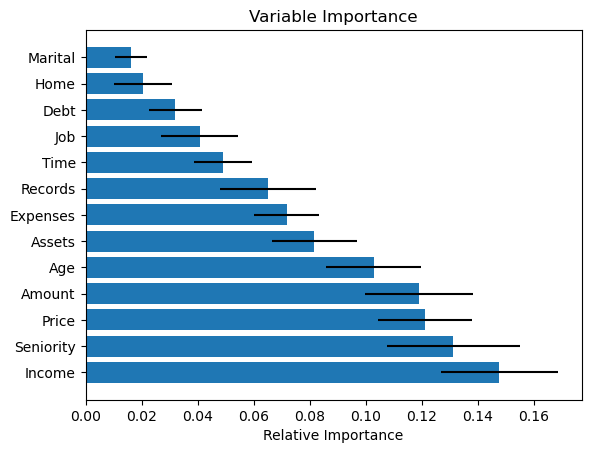

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state = 1)
clf.fit(xtrain_ss, ytrain)
importances=clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
sorted_idx = np.argsort(importances)[::-1]
features = pd_credit.columns.values
print(features[sorted_idx])
padding = np.arange(xtrain_ss.size/len(xtrain_ss)) + 0.5 
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center') 
plt.yticks(padding, features[sorted_idx]) 
plt.xlabel("Relative Importance")
plt.title("Variable Importance") 
plt.show()

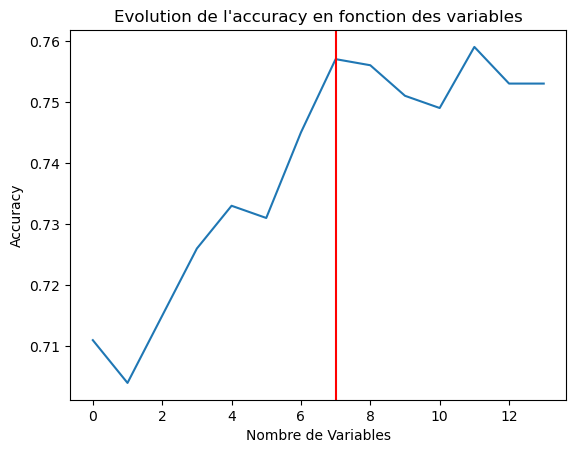

In [ ]:
KNN=KNeighborsClassifier(n_neighbors=5)
scores=np.zeros(xtrain_ss.shape[1]+1)
for f in np.arange(0, xtrain_ss.shape[1]+1):
    X1_f = xtrain_ss[:,sorted_idx[:f+1]]
    X2_f = xtest_ss[:,sorted_idx[:f+1]]
    KNN.fit(X1_f,ytrain)
    YKNN=KNN.predict(X2_f)
    scores[f]=np.round(accuracy_score(ytest,YKNN),3)
plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Accuracy")
plt.title("Evolution de l'accuracy en fonction des variables")
plt.axvline(x=7, color="red")
plt.show()

In [ ]:
X_trimmed = np_credit[:, sorted_idx[:8]]

# Y ne change pas, et avec random_state constant, ytrain et ytest non plus
xtrain_trim, xtest_trim, ytrain, ytest = train_test_split(X_trimmed, Y, test_size=0.5, random_state=1)

stdScale=StandardScaler()
stdScale.fit(xtrain_trim)

xtrain_trim_ss = stdScale.transform(xtrain_trim)
xtest_trim_ss = stdScale.transform(xtest_trim)

# TEXT A REVOIR

now on work avec des données moins bruités (trimmed) + normalized stdscale

## 6) Paramétrage des classifieurs :

In [ ]:
from sklearn.model_selection import GridSearchCV
from os.path import exists
from pickle import load, dump

def find_best_param(sk_function, params, X_train, Y_train):
    file_name = f"../res/pickle/gs_{sk_function.__name__}.pkl"

    if exists(file_name):
        gs = load(open(file_name, "rb"))

    else:
        gs = GridSearchCV(sk_function(), params, scoring="precision") #we target the best precision score)
        gs.fit(X_train, Y_train)
        dump(gs, open(file_name, "wb"))
    
    print(f"Best params for '{sk_function.__name__}' is \n{gs.best_params_}\n")
    return gs

In [ ]:
# KNN test
parameters_knn = {
    "n_neighbors" : [i for i in range(1, 100, 5)],
    "weights" : ["uniform", "distance"],
    "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute']
}
gs_knn = find_best_param(KNeighborsClassifier, parameters_knn, xtrain_trim_ss, ytrain)

# CART test
parameters_cart = {
    "criterion" : ["gini", "entropy", "log_loss"],
    "splitter" : ["best", "random"],
    "max_depth" : [i for i in range(1, 16)],
    "min_samples_leaf" : [i for i in range(1, 16)],
    "min_samples_split" : [i for i in range(1, 16)]
}
gs_cart = find_best_param(DecisionTreeClassifier, parameters_cart, xtrain_trim_ss, ytrain)

# MLP test
parameters_mlp = {
    "activation" : ["identity", "logistic", "tanh", "relu"],
    "hidden_layer_sizes" : [(l1, l2) for l1 in range(10, 121, 10) for l2 in range(10, 81, 10)]
}
gs_mlp = find_best_param(MLPClassifier, parameters_mlp, xtrain_trim_ss, ytrain)

Best params for 'KNeighborsClassifier' is 
{'algorithm': 'auto', 'n_neighbors': 6, 'weights': 'uniform'}

Best params for 'DecisionTreeClassifier' is 
{'criterion': 'log_loss', 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 13, 'splitter': 'random'}

Best params for 'MLPClassifier' is 
{'activation': 'relu', 'hidden_layer_sizes': (70, 30)}



# TEXT A REVOIR

blablabla

## 7) Création d'un pipeline :

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

SIGNIFICANCE_COLS = sorted_idx[:8]
COLS_EVAL_2 = ["method", "accuracy", "precision", "params"]

def make_pipeline(X_train, Y_train, sk_function, params):
    # describe the pipeline
    trim = ColumnTransformer([("trim", "passthrough", SIGNIFICANCE_COLS)]) # trim data with 7 best variables
    # StdScaling data
    trim_ss = Pipeline([
        ("trim", trim), 
        ('stdScale', StandardScaler())
    ])
    # StdScaling data then get 3 first PCA axis 
    trim_ss_pca3 = Pipeline([
        ("trim", trim), 
        ('stdScale', StandardScaler()), 
        ('pca3comp', PCA(n_components=3))
    ])
    # bind 3 frist PCA axis to the scaled data
    prep_data = FeatureUnion([
        ('trim + stdScale', trim_ss),
        ('trim + stdScale + pca3comp', trim_ss_pca3)
    ]) 
    # then add estimator
    pipeline = Pipeline([
        ('preprocess', prep_data), 
        ('model', sk_function(**params))
    ]) 
    
    # train the pipeline
    pipeline.fit(X_train, Y_train)

    # save the pipeline with pickle
    dump(pipeline, open(f"../res/pickle/pipe_{sk_function.__name__}.pkl", "wb"))

    # display the 'html' description of the pipeline
    display(pipeline)


def test_pipeline(pipelines, X_test, Y_test):
    df = pd.DataFrame(columns=COLS_EVAL_2)
    for pipe in pipelines:
        Y_pred = pipe.predict(X_test)
        dict_line = {
            "method" : pipe.named_steps['model'].__class__.__name__,
            "accuracy" : pipe.score(X_test, Y_test),
            "precision" : precision_score(Y_test, Y_pred),
            "params" : [pipe.named_steps['model']]
        }
        df_line = pd.DataFrame(dict_line, columns=COLS_EVAL_2)
        df = pd.concat([df, df_line], ignore_index=True)
    return df

In [ ]:
# making pipeline and save it as pickle
make_pipeline(xtrain, ytrain, KNeighborsClassifier, gs_knn.best_params_)
make_pipeline(xtrain, ytrain, DecisionTreeClassifier, gs_cart.best_params_)
make_pipeline(xtrain, ytrain, MLPClassifier, gs_mlp.best_params_)

# load pipeline
pipe_KNN = load(open("../res/pickle/pipe_KNeighborsClassifier.pkl", "rb"))
pipe_CART = load(open("../res/pickle/pipe_DecisionTreeClassifier.pkl", "rb"))
pipe_MLP = load(open("../res/pickle/pipe_MLPClassifier.pkl", "rb"))

# test
test_pipe = test_pipeline([pipe_KNN, pipe_CART, pipe_MLP], xtest, ytest)
display(test_pipe)

# to use a model:
# 1) load it : mymodel = pickle.load("path_of_the_model", "rb")
# 
# 2) use it : Y_prediction = mymodel.predict(X_data)
# X_data is a numpy array !

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('trim + stdScale',
                                                 Pipeline(steps=[('trim',
                                                                  ColumnTransformer(transformers=[('trim',
                                                                                                   'passthrough',
                                                                                                   array([ 8,  0, 12, 11,  3,  9,  7,  5]))])),
                                                                 ('stdScale',
                                                                  StandardScaler())])),
                                                ('trim + stdScale + pca3comp',
                                                 Pipeline(steps=[('trim',
                                                                  ColumnTransformer(transformers=[('trim',
                                                                                                   'passthrough',
                                                                                                   array([ 8,  0, 12, 11,  3,  9,  7,  5]))])),
                                                                 ('stdScale',
                                                                  StandardScaler()),
                                                                 ('pca3comp',
                                                                  PCA(n_components=3))]))])),
                ('model', KNeighborsClassifier(n_neighbors=6))])

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('trim + stdScale',
                                                 Pipeline(steps=[('trim',
                                                                  ColumnTransformer(transformers=[('trim',
                                                                                                   'passthrough',
                                                                                                   array([ 8,  0, 12, 11,  3,  9,  7,  5]))])),
                                                                 ('stdScale',
                                                                  StandardScaler())])),
                                                ('trim + stdScale + pca3comp',
                                                 Pipeline(steps=[('trim',
                                                                  ColumnTransformer(transformers=[('trim',
                                                                                                   'passthrough',
                                                                                                   array([ 8,  0, 12, 11,  3,  9,  7,  5]))])),
                                                                 ('stdScale',
                                                                  StandardScaler()),
                                                                 ('pca3comp',
                                                                  PCA(n_components=3))]))])),
                ('model',
                 DecisionTreeClassifier(criterion='log_loss', max_depth=15,
                                        min_samples_leaf=3,
                                        min_samples_split=13,
                                        splitter='random'))])

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('trim + stdScale',
                                                 Pipeline(steps=[('trim',
                                                                  ColumnTransformer(transformers=[('trim',
                                                                                                   'passthrough',
                                                                                                   array([ 8,  0, 12, 11,  3,  9,  7,  5]))])),
                                                                 ('stdScale',
                                                                  StandardScaler())])),
                                                ('trim + stdScale + pca3comp',
                                                 Pipeline(steps=[('trim',
                                                                  ColumnTransformer(transformers=[('trim',
                                                                                                   'passthrough',
                                                                                                   array([ 8,  0, 12, 11,  3,  9,  7,  5]))])),
                                                                 ('stdScale',
                                                                  StandardScaler()),
                                                                 ('pca3comp',
                                                                  PCA(n_components=3))]))])),
                ('model', MLPClassifier(hidden_layer_sizes=(70, 30)))])

,method,accuracy,precision,params
0,KNeighborsClassifier,0.744059,0.832036,KNeighborsClassifier(n_neighbors=6)
1,DecisionTreeClassifier,0.723035,0.815077,"DecisionTreeClassifier(criterion='log_loss', m..."
2,MLPClassifier,0.776508,0.835684,"MLPClassifier(hidden_layer_sizes=(70, 30))"


## 8) Comparaison de plusieurs algorithmes d’apprentissage :

In [ ]:
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier)
from sklearn.naive_bayes import GaussianNB

classifiers = { 
  'RF_10': RandomForestClassifier(n_estimators=10, random_state=1),
  'RF_20': RandomForestClassifier(n_estimators=20, random_state=1),
  'RF_40': RandomForestClassifier(n_estimators=40, random_state=1),
  'RF_80': RandomForestClassifier(n_estimators=80, random_state=1),
  'RF_120': RandomForestClassifier(n_estimators=120, random_state=1),

  "NB": GaussianNB(),

  "MLP_20_10" : MLPClassifier(hidden_layer_sizes=(20,10), random_state=1),
  "MLP_40_20" : MLPClassifier(hidden_layer_sizes=(40,20), random_state=1),
  "MLP_60_30" : MLPClassifier(hidden_layer_sizes=(60,30), random_state=1),

  "CART_gini" : DecisionTreeClassifier(criterion="gini", random_state=1),
  "CART_entropy" : DecisionTreeClassifier(criterion="entropy", random_state=1),
  "CART_log_loss" : DecisionTreeClassifier(criterion="log_loss", random_state=1),
  
  "KNN_10" : KNeighborsClassifier(n_neighbors=10),
  "KNN_20" : KNeighborsClassifier(n_neighbors=20),
  "KNN_40" : KNeighborsClassifier(n_neighbors=40),
  "KNN_80" :  KNeighborsClassifier(n_neighbors=80),
  "KNN_120" :  KNeighborsClassifier(n_neighbors=120),

  "Bag_10" : BaggingClassifier(n_estimators=10, random_state=1),
  "Bag_20" : BaggingClassifier(n_estimators=20, random_state=1),
  "Bag_40" : BaggingClassifier(n_estimators=40, random_state=1),
  "Bag_80" : BaggingClassifier(n_estimators=80, random_state=1),
  "Bag_120" : BaggingClassifier(n_estimators=120, random_state=1),

  "AdaB_10" : AdaBoostClassifier(n_estimators=10, random_state=1),
  "AdaB_20" : AdaBoostClassifier(n_estimators=20, random_state=1),
  "AdaB_40" : AdaBoostClassifier(n_estimators=40, random_state=1),
  "AdaB_80" : AdaBoostClassifier(n_estimators=80, random_state=1),
  "AdaB_120" : AdaBoostClassifier(n_estimators=120, random_state=1)
}

In [ ]:
from sklearn.model_selection import (cross_validate, KFold)
from sys import stderr

def log_msg(msg):
    space=" "
    print(f"\r{space*80}", file=stderr, end="")
    print(f"\r{msg}", file=stderr, end="")

COLS_EVAL_3 = ['method', 'test_precision_mean', 'test_precision_sd', 
    'test_accuracy_mean', 'test_accuracy_sd','test_roc_auc_mean', 'test_roc_auc_sd',
    'fit_time_mean', 'fit_time_sd', 'score_time_mean', 'score_time_sd',
]

def run_classifiers(sk_func_dict, X, Y, nb_split=10):
    df = pd.DataFrame(columns=COLS_EVAL_3)
    kf = KFold(n_splits=nb_split, shuffle=True, random_state=0)
    size_clfs = len(sk_func_dict)
    for idx, key in enumerate(sk_func_dict):
        log_msg(f"{key} is running! ({idx+1}/{size_clfs})")
        
        cv_metrics = cross_validate(sk_func_dict[key], X, Y, cv=kf, scoring=['accuracy', 'precision', 'roc_auc'])
        dict_metrics = {i:{'mean':np.mean(v), 'sd':np.std(v)} for i, v in cv_metrics.items()}
        dict_metrics["method"] = key
        df_metrics = pd.json_normalize(dict_metrics, sep="_")
        df = pd.concat([df, df_metrics], ignore_index=True)
    print("")
    return df

In [ ]:
run1 = run_classifiers(classifiers, X, Y, nb_split=10)
display(run1)

AdaB_120 is running! (26/27)                                                    

,method,test_precision_mean,test_precision_sd,test_accuracy_mean,test_accuracy_sd,test_roc_auc_mean,test_roc_auc_sd,fit_time_mean,fit_time_sd,score_time_mean,score_time_sd
0,RF_10,0.827443,0.020155,0.762506,0.018181,0.787848,0.015157,0.030326,0.005744,0.003121,0.001059
1,RF_20,0.827946,0.014783,0.780110,0.015252,0.809909,0.015221,0.053587,0.000604,0.004018,0.000104
2,RF_40,0.823234,0.018392,0.785594,0.015826,0.821258,0.015262,0.106666,0.000963,0.006882,0.000092
3,RF_80,0.817582,0.018526,0.783312,0.015981,0.827913,0.015687,0.211965,0.001402,0.012683,0.000271
4,RF_120,0.815806,0.019338,0.781937,0.016233,0.829633,0.016183,0.317814,0.003669,0.018482,0.000257
5,NB,0.828111,0.017918,0.772109,0.021881,0.790916,0.025893,0.000721,0.000035,0.000968,0.000061
6,MLP_20_10,0.812109,0.065149,0.661296,0.098098,0.722601,0.032454,0.205312,0.026801,0.001151,0.000044
7,MLP_40_20,0.780818,0.039638,0.701041,0.055151,0.680986,0.030934,0.236442,0.055713,0.001726,0.000633
8,MLP_60_30,0.788043,0.063994,0.695761,0.104288,0.683273,0.070349,0.566491,0.160267,0.002468,0.001298
9,CART_gini,0.807787,0.022375,0.726862,0.025165,0.655571,0.031839,0.017339,0.004662,0.002075,0.001273


# II) Apprentissage supervisé : Données hétérogènes

## 

In [470]:
CREDIT_SCORE_HET = "../data/credit.data"

pd_credit_het = pd.read_csv(CREDIT_SCORE_HET, sep="\t", header=None, na_values="?")

pd_credit_het.head()

df = pd_credit_het

s = df.stack(dropna=False)
L = [x for x in s.index[s.isna()]]

print(L)


[(71, 13), (83, 1), (86, 1), (92, 1), (97, 1), (241, 13), (246, 0), (252, 1), (268, 3), (268, 4), (268, 5), (268, 6), (268, 13), (276, 13), (284, 1), (325, 0), (327, 1), (328, 3), (328, 4), (328, 5), (328, 6), (328, 13), (344, 0), (372, 0), (404, 13), (443, 1), (443, 13), (448, 1), (451, 0), (454, 3), (454, 4), (454, 5), (454, 6), (454, 13), (477, 0), (477, 5), (477, 6), (487, 0), (498, 1), (513, 1), (518, 0), (537, 5), (537, 6), (590, 3), (590, 4), (590, 5), (590, 6), (590, 13), (596, 0), (599, 0), (599, 5), (599, 6), (606, 1), (620, 3), (620, 4), (620, 5), (620, 6), (620, 13), (624, 13), (639, 0), (671, 0)]


In [426]:
# pd_credit_het[15] = pd_credit_het[15].apply(lambda x: 1 if x == "+" else 0) 
# for i in BOOL_COLS:
#     pd_credit_het[i] = pd_credit_het[i].apply(lambda x: 1 if x == "t" else 0)
pd_credit_het = pd_credit_het.astype(TYPE_COLS)


pd_credit_het.shape

(688, 16)

In [ ]:
np_credit_het_str, np_credit_het_num = pd_credit_het[STR_COLS].values, pd_credit_het[NUM_COLS + BOOL_COLS].values

In [ ]:
txt = f"""Le jeu de donnée présente:
    {X.shape[0]:<6d} enregistrements
    {X.shape[1]:<6d} variables explicatives
    {1:<6d} variable label/classification

Concernant la classification, elle est binaire (0 ou 1) avec:
    {int(Y.sum()):<6d} classe 1 = solvable
    {int(len(Y) - Y.sum()):<6d} classe 0 = non solvable 
"""
print(txt)

display(pd_credithet_.head())

In [ ]:
ok = pd.read_csv(CREDIT_SCORE_HET, sep="\t", header=None, na_values="?")
d={i : count(ok[i]) for i in ok.columns}
dd={i:sorted(list(v.values()), reverse=True) for i,v in d.items()}


In [564]:
from matplotlib.patches import Patch


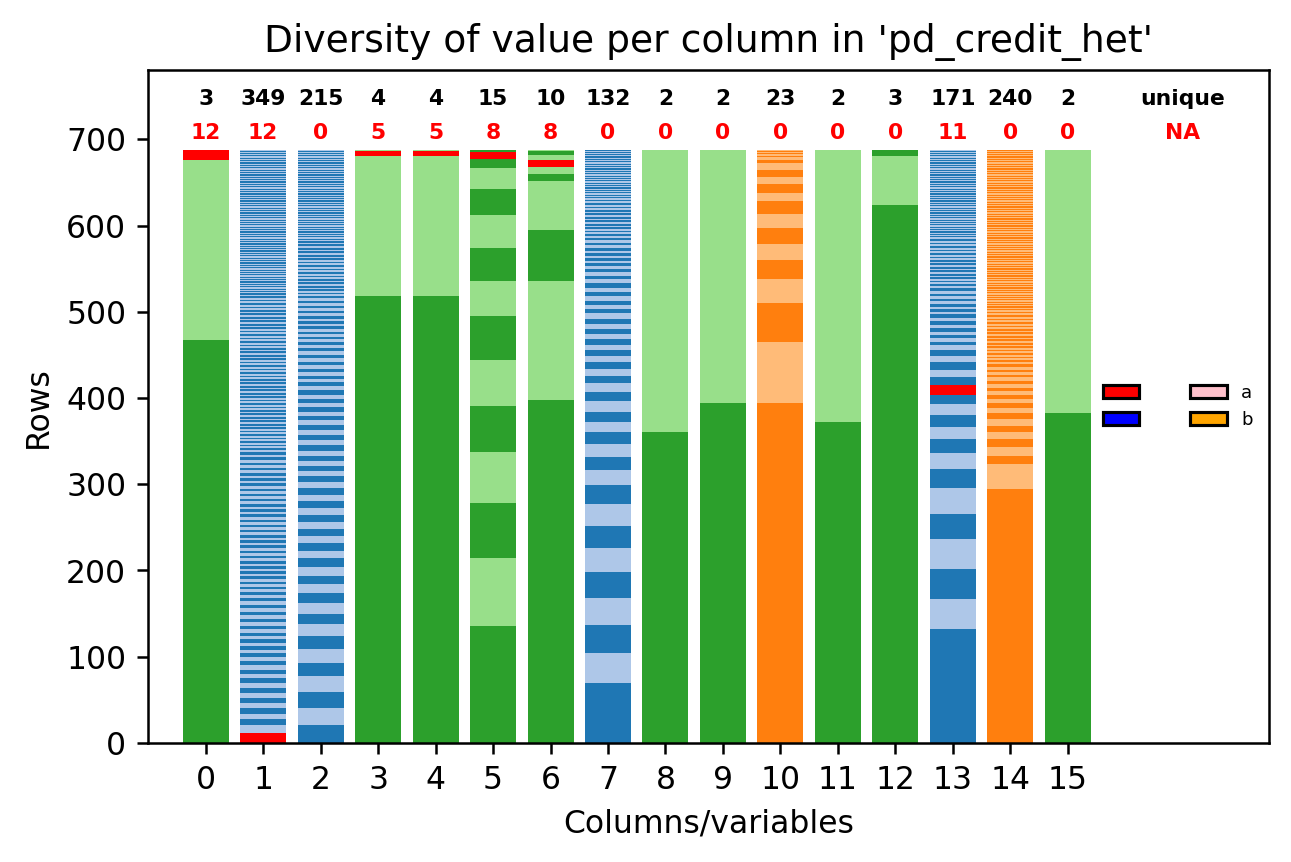

In [582]:
f, a = plt.subplots(dpi=226)
a.set_ylim([0, 780])
a.set_xlim([-1, 18.5])
a.set_box_aspect(0.6)

a.bar([], [], color=color[0], label="ok")
a.bar([], [], color=color[1], label="ok")

pa1 = Patch(facecolor='red', edgecolor='black')
pa2 = Patch(facecolor='blue', edgecolor='black')
pa3 = Patch(facecolor='green', edgecolor='black')
#
pb1 = Patch(facecolor='pink', edgecolor='black')
pb2 = Patch(facecolor='orange', edgecolor='black')
pb3 = Patch(facecolor='purple', edgecolor='black')

txt_args = {'horizontalalignment':'center', 'fontweight':'bold', 'fontsize':'x-small'}

for col in pd_credit_het.columns:
    cumul = 0
    serie = pd_credit_het[col]

    count = serie.value_counts(dropna=False).sort_values(ascending=False)
    for idx, item in enumerate(count.items()): 
        val, cnt = item
        
        if pd.isna(val):
            c = "r"
        elif isinstance(val, float):
            c = color[0] if idx%2 == 0 else color[1]
        elif isinstance(val, int):
            c = color[2] if idx%2 == 0 else color[3]
        elif isinstance(val, str):
            c = color[4] if idx%2 == 0 else color[5]
        else:
            print("err")
        
        a.bar(str(col), cnt, bottom=cumul, color=c)

        
        cumul += cnt
    a.text(col, 740, count.shape[0], **txt_args)
    a.text(col, 700, serie.isna().sum(), color="red", **txt_args)

a.text(17, 740, "unique", **txt_args)
a.text(17, 700, "NA", color="red", **txt_args)
a.set_title("Diversity of value per column in 'pd_credit_het'")
a.set_ylabel("Rows")
a.set_xlabel("Columns/variables")

a.legend(handles = (pa1, pa2, pb1, pb2), labels=("", "", 'a', "b"), ncol=2, loc='right', fontsize='xx-small', frameon=False)


Text(0.5, 0, 'Columns/variables')

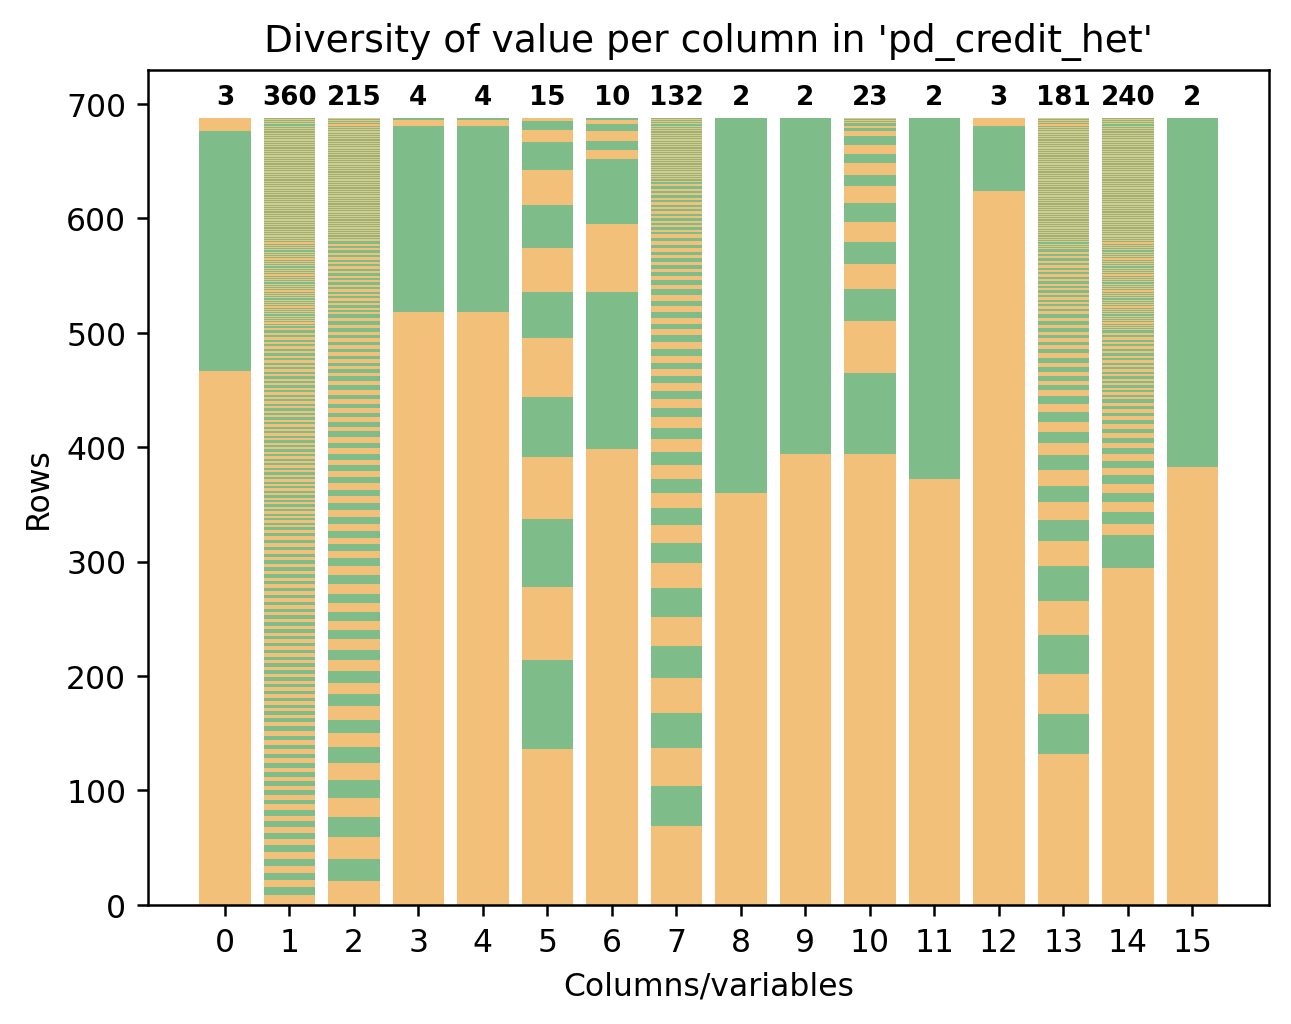

In [411]:
f, a = plt.subplots(dpi=226)
a.set_ylim([0, 760])

for col, unq in sorted(list(dd.items()),key=lambda x:x[0]):
    cumul = 0
    for i, v in enumerate(unq):
        c = "#f2c078" if i%2==0 else "#7ebc89"
        a.bar(str(col), height=v, bottom=cumul, color=c)
        
        cumul += v
    t = 1 if col%2==0 else 1.5
    a.text(col, 730, len(unq), horizontalalignment='center', fontweight='bold', fontsize='small')



#plt.figtext(40, 40, "ok")


In [ ]:
list(map(lambda x:x/255, (126, 188, 137)))

[0.49411764705882355, 0.7372549019607844, 0.5372549019607843]

In [ ]:
a=pd.unique(ok[10]).tolist()
a.sort()
print(a)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 23, 40, 67]


In [ ]:
def count(li):
    c={}
    for i in li:
        c[i] = c[i] + 1 if i in c else 1
    return c


{0: 2,
 1: 2,
 2: 2,
 3: 2,
 4: 2,
 5: 2,
 6: 2,
 7: 2,
 8: 2,
 9: 2,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1}